University of Zagreb<br/>
Faculty of Electrical Engineering and Computing<br/>
Department of Electronic Systems and Information Processing

Academic year 2021/2022

## **5th laboratory exercise: Image restoration**

*Digital Image Processing and Analysis* (183463)

Date: 2022-03-10

Please send any feedback (corrections, comments, suggestions etc.) regarding this document to branimir.filipovic@fer.hr.

© University of Zagreb Faculty of Electrical Engineering and Computing, 2021.

Permission is granted to make and distribute copies of this instructions provided the copyright notice and this permission notice are preserved on all copies.

# Introduction

Instructions for laboratory exercises for the course *Digital Image Processing and Analysis* are prepared in a form of a <a href="https://jupyter.org/">Jupyter</a> notebooks.

All problems in prepared notebook are intended to be completed in Python using <a href="https://colab.research.google.com">Google Colaboratory</a> platform (Colab for short).

## How to Submit Your Laboratory Report

Simply write-in your code to all empty code cells and write in your answers to the text cells with questions.

Empty code cells contain the placeholder text `# Write-in your solution` while text cells where you have to write-in someting contain a bold uppercase text **WRITE YOUR ANSWER HERE**.

Once you have completed all problems save this notebook locally in a file named DIPA_LAB_X_NAME_SURNAME.ipynb,
where X is the exercise number, and submit it via Moodle under the appropriate upload section.

Your submissions will be first automatically re-evaluated which corresponds to selecting the *Runtime/Restart and run all* command in Colab. Therefore, it is strongly suggested that you run this command yourself before submitting your notebook. Another thing to do before submission is to clear all the cell outputs by selecting *Edit/Clear all outputs*. This will reduce the size of .ipynb files for upload.

## Student Information

Before proceeding double click on this text and then fill in your name:

Name: Enio Krizman

Student ID number (JMBAG): 0069083848

## Suggested Reading

### General Reading

If you are not familiar with Python then start with a Python tutorial such as e.g. an official one available at <a href="https://docs.python.org/3/tutorial/">https://docs.python.org/3/tutorial/</a>.

Jupyter notebooks are relying on <a href="https://ipython.org/">IPython</a>, which is an interactive Python interpreter. Jupyter notebooks may be run locally or they may be conveniently executed remotely in Google Colaboratory via web browser.

Readers familiar with Matlab who have only basic knowledge of Python are strongly encouraged to read the document <a href="https://numpy.org/doc/stable/user/numpy-for-matlab-users.html">NumPy for Matlab users</a> before attempting to solve this laboratory exercise in Colab.

### Image Processing in Python

Some general image processing functions are available as a part of [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html). This basic functionality is extended by the [`scikit-image`](https://scikit-image.org/). We will also use [OpenCV](https://opencv.org/).

#Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importing Required Functions

To simplify the code in Python in this notebook we may deliberately import functions from <a href="https://www.scipy.org/">SciPy</a>, <a href="https://numpy.org/">NumPy</a> and <a href="https://matplotlib.org/">Matplotlib</a> directly into the global namespace so e.g. we can write `fft` instead of `scipy.fft.fft`.

Please keep in mind that such an approach may be tolerated for the purpose of a short laboratory exercise where risks of collisions and side effects are minimal. It is best always avoided in production code.

If you prefer to use namespaces then feel free to change the import statements to retain strict package separation, e.g. `import numpy as np`.

In [ ]:
# Import packages
import cv2
import skimage.io

# To display images in browser
from google.colab.patches import cv2_imshow

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import * 
from scipy.stats import *
from skimage.filters import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *

## Image loading

We will be using images from the [USC-SIPI database](http://sipi.usc.edu/database/) and additional images available on the [DIPA class webpage](https://www.fer.unizg.hr/en/course/dipaa_b/laboratory#%23!p_rep_139398!_-187329). To load any of these images, all we have to do is copy the URL of the image and write the following two lines of code.

In [ ]:
url = "http://sipi.usc.edu/database/preview/misc/5.3.02.png"
img = skimage.io.imread(url, plugin = 'pil')

## Image representations

[Grayscale](https://en.wikipedia.org/wiki/Grayscale) images are composed of pixels representing a grayscale value. In a computer a 2D grayscale image is represented as an $M \times N$ matrix of pixel values, which represent light intensity. 

It takes several such matrices for colored images - one for each color channel. There are several color models used for color image representation. For instance, an [RGB](https://en.wikipedia.org/wiki/RGB_color_model) image has three channels (for red, green and blue color) so an $M \times N \times 3$ matrix is used.   Color images can be converted to grayscale images, usually by calculating a weighted sum of the channels. The [cv2.cvtColor()](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function is used to convert images from one color space to another.

These representations allow the use of common matrix operators for image processing and analysis. 

In [ ]:
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img = skimage.io.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # openCV uses BGR (blue, green, red) representation
cv2_imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

# 5.1 Image acquisition systems

Working with image acquisition systems (such as telescopes, cameras or medical imaging equipment), we
will encounter terms such as point spread function (PSF) (or sometimes blur kernel) and optical transfer
function (OTF). Point spread function is the system’s response to a point source of light, or in linear
systems terminology, it is the impulse response ($h$) of a linear system, since the point source of light can be
approximated by a delta function. Optical transfer function is the transfer function ($H$) of the acquisition system,
and is defined as the Fourier transform of the point spread function.

Let’s assume we’re observing a part of a night sky, which looks like the input image shown in the Fig.
5.1. Also, we assume that our telescope (image acquisition device) is completely described with its transfer
function, and that it does not add sensor noise or any other noise (such as atmospheric noise). If the point
spread function is known, then the acquired image will look as the output image in the Fig. 5.1. You can
notice that acquisition system changes the input image.

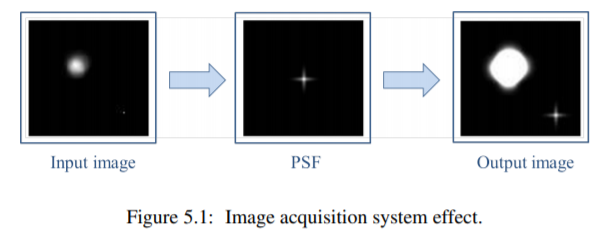

As we’ve learned before, the system’s response (output) is obtained by convolution of the input image $I$
with the imuplse response $h$ in the spatial domain, or by multiplication of the Fourier transform of the image
and the transfer function in the frequency domain.

If we only have the acquired image, and we want to restore the original (non-distorted) image
should look like, we can perform deconvolution, ie. we can define an inverse filter which removes the
image degradation effect of the acquisition system. Assuming that we know the OTF (or PSF) of the acquisition
system ($H(k,l)$), and if it is a spatially invariant system, we can define the inverse system as:
\begin{equation}
H_{i}(k, l)=\frac{1}{H(k, l)} \tag{5.1}
\end{equation}

Pseudo-inverse system is defined as:
 \begin{equation}
H_{p i}(k, l)=\left\{\begin{array}{ll}
\frac{1}{H(k, l)} & \forall H(k, l)>K \\
0 & \forall H(k, l) \leq K
\end{array}\right. \tag{5.2}
\end{equation}
where K is and arbitrarily chosen constant.

All details on these filters are explained further in this exercise.

## 5.1.1. Problems
1. Write a function which will take a degraded image and the PSF (modeled as an impulse response of finite dimensions) as inputs and calculate the original image using the inverse and pseudoinverse filter. (Note: Mind the difference between the linear and circular convolution, as explained in previous exercises.)

In [ ]:
def restore(imgD, psf, filter='inverse'):
    H = np.zeros((imgD.shape[0], imgD.shape[1]))
    H[0: psf.shape[0], 0: psf.shape[1]] = psf
    pseudo_inv = np.zeros((imgD.shape[0], imgD.shape[1]))
    if filter == 'inverse':
      img = np.abs(ifft2(fft2(imgD)*1/fft2(H)))
      imgR = img.astype(np.uint8)
      
    elif filter == 'pseudo':
      img1 = fft2(imgD)
      img2 = fft2(H)
      for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):
          if img2[i][j] <=0:
            img2[i][j]= 100000000
      img = np.abs(ifft2(img1*1/img2))
      imgR = img.astype(np.uint8)

    return imgR

# 5.2  Image restoration
The goal of image restoration is to obtain an image as similar as possible to the original image, from the degraded image and the knowledge of a degradation model. Unlike image enhancement, which is an ill-posed problem, image restoration is a well defined problem. Degradation is usually modeled as
a complex system containing linear memory system and memoryless nonlinearity. Besides that, real-life systems always introduce the noise, which is usually modeled as additive noise. Neglecting the memoryless nonlinearity, the process of degradation and image restoration can be shown with the Fig. 5.2.




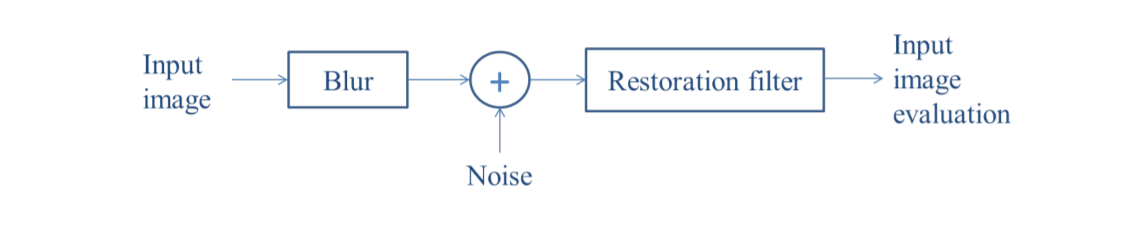

**Figure 5.2:** Scheme of the experiment. Blurring will be approximated with a linear system, and sensor noise
with the additive noise. Other noises are neglected. Restoration filter is used to try to obtain the original
(input) image. We emphasize that this is only an estimation, which is only as correct as the assumed model.


# 5.3 Modeling the degradation as a FIR filter
A linear system that represents the degradation function will be modeled as a [FIR (Finite Impulse Response) filter](https://en.wikipedia.org/wiki/Finite_impulse_response) which can be defined with its impulse response. For constructing different responses, we can use OpenCV and Numpy.

Since we will model all degradation as linear spatial invariant systems, the result obtained with this degradation can be obtained with linear convolution. If we want to apply several different degradation models (for example atmospheric blur and camera shift), we need to perform several consecutive convolutions. The response of such complex system can also be obtained by calculating linear convolution of each of the systems' responses.

In the following example, the weak atmospheric blur is modeled with a Gaussian-shaped filter, while the uniform camera shift in the horizontal and vertical direction is modeled with a 20 pixel shift per $x$ and $y$-axis simultaneously.

## Example:

In [ ]:
# DEFINITION OF THE DEGRADATION SYSTEM
h1=np.identity(20)/20                       # uniform shift
h2=cv2.getGaussianKernel(ksize=5, sigma=1)  # 1-D Gaussian kernel
plt.stem(h2)                                # display the 1-D Gaussian blurring imp. response in the spatial domain
plt.show()

h2_2D=np.outer(h2, h2)                      # 2-D Gaussian kernel
H2_2D=fft2(h2_2D)                           # frequency response of the Gaussian blurring
plt.imshow(np.abs(H2_2D), cmap='gray')      # display the 2-D Gaussian blurring transfer function (OTF)
plt.show()

h=convolve2d(h1, h2_2D)                     # the total blur is the convolution of the two impulse responses
print(h.shape)
plt.imshow(np.abs(h), cmap='gray')          # total impulse response in the spatial domain
plt.show()

# APPLICATION
img = cv2.imread('/content/drive/MyDrive/Images/moon.tif')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgB = convolve2d(img,h)                    # apply the blur
plt.imshow(imgB, cmap='gray')               # display the degraded image

### **5.3.1 Problems**

1. Define the PSF and the OTF for typical blurs: 1) weak atmospheric blur - see *Image Restoration* lecture presentation, 2) vertical and horizontal
shift (for several pixels) simultaneously (a single function that covers both shifts).

In [ ]:
#Weak atmosphereic blur

def weak_atmospheric_blur(alpha , N):
  result = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      result[i][j] = math.exp(-math.pi*(alpha*alpha)*(i*i+j*j))
  return result

def shift_vertical_horizontal(N):
  result= np.identity(N)/N
  return result


2. Define the PSF and the OTF for a combination of the 2 mentioned blurs: weak atmospheric blur +
vertical and horizontal shift for 10 pixels. The function obtained here will be used in the following
problems in this group.


In [ ]:
# Write-in your solution
psf = weak_atmospheric_blur(0.8 , 5)
otf = shift_vertical_horizontal(10)

function= convolve2d(psf,otf)


3. Apply the obtained PSF on the image salona.png (or 2.2.01.tiff or 2.1.08.tiff).

In [ ]:
# Write-in your solution
img = cv2.imread('/content/drive/MyDrive/Images/salona.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img , cmap='gray')
plt.show()

img_result = convolve2d(img, function)

plt.imshow(img_result , cmap='gray')
plt.show()

4. Apply the obtained PSF on the image klis1.jpg for each of the channels separately. Display the obtained RGB image. Explain where does the black frame come from. What does its width depend on?

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/klis1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

(b,g,r) = cv2.split(img)
blue = convolve2d(b, function)
green = convolve2d(g, function)
red = convolve2d(r, function)

result = cv2.merge([blue,green,red])
cv2_imshow(result)

Kada pomičemo piksele za neko određeno pomicanje nema piksela koji mogu nadopuniti pomaknute pa se na to mjesto stavljaju crni pikseli.

# 5.4 Inverse filter
Inverse filter is defined with the Eq. 5.1.
Since this expression is literally calculation of an inverse, the obtained filter can be unstable. Besides
unstability, for most of the purposes this filter is not really efficient due to its great sensitivity to noise.
Because of the inevitable quantization to the definite number of discrete levels, even in the case of negligible
additive noise, the quantization is always present.
To get the error (due to the quantization or other degradations) we can calculate mean square error (MSE), as given in the following example.
Sometimes we also wish to know the power ratio of signal and noise, or even the power ratio of original signal and reconstructed signal. Note: Power ratios can also be calculated in decibels!


## Example:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/klis1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
imgO = convolve2d(img, function, mode='same')
imgR = restore(imgO, function,'inverse')               #restoring the image using the function you wrote - problems 5.1.1

# MSE
img = img/255                         # switch to float and rescale to [0,1]
imgR = imgR/255                       # the second image as well
print(img.shape, imgR.shape)
err = np.mean((img-imgR)**2);         # calculate mean square error

# POWER RATIOS
imgP = np.abs(fft2(img))**2           # power spectrum of the original image
imgP_mean = np.mean(imgP)             # mean power of the original image
imgRP = np.abs(fft2(imgR))**2         # power spectrum of the restored image
imgRP_mean = np.mean(imgRP)           # mean power of the restored image
PR = imgP_mean/imgRP_mean             # original-to-restored image power ratio

print("err:", err, "\nimgP_mean:", imgP_mean, "\nimgOP_mean:", imgRP_mean, "\nPR:", PR)

Since it can be difficult to visualize the filter performance by comparing whole images before and after
filtering, we can compare only their columns or rows, which are 1D signals:

## Example:

In [ ]:
print(imgB.shape) # get the image size (height and width)
rowB = imgB[128,:] # get the 128th row of the original image
rowR = imgR[128,:]; # get the 128th row of the reconstructed image
plt.plot(rowB,'r') # show them simultaneously
plt.plot(rowR,'b')

### **5.4.1 Problems**
1. For the selected degradation (its PSF), display the result of inverse filtering for a case of: 1) degradation **without** additive noise and 2) degradation **with** additive noise for 2 images.

In [ ]:
# Write-in your solution
img1 = cv2.imread('/content/drive/MyDrive/Images/detalj.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2 = cv2.imread('/content/drive/MyDrive/Images/medalja_dubrovnik.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

filter = np.array(
       [[1, 2, 0],
        [1, 5, 2],
        [0, 2, 3]]) / 8

img1_f = convolve2d(img1, filter, mode='same')
img1_without_noise = restore(img1_f, filter, 'inverse')
img1_f1 = img1_f + np.random.normal(0, 1, img1_f.shape)
img1_noise = restore(img1_f1, filter, 'inverse')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img1, cmap='gray')
axs[0, 1].imshow(img1_f, cmap='gray')
axs[1, 0].imshow(img1_without_noise, cmap='gray')
axs[1, 1].imshow(img1_noise, cmap='gray')
fig.show()

img2_f = convolve2d(img2, filter, mode='same')
img2_without_noise = restore(img2_f, filter, 'inverse')
img2_f1 = img2_f + np.random.normal(0, 1, img2_f.shape)
img2_noise = restore(img2_f1, filter, 'inverse')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img2, cmap='gray')
axs[0, 1].imshow(img2_f, cmap='gray')
axs[1, 0].imshow(img2_without_noise, cmap='gray')
axs[1, 1].imshow(img2_noise, cmap='gray')
fig.show()


2. Calculate the MSE (between the reconstructed and original image) for both cases from the previous
problem.

In [ ]:
def MSE(img_1,img_2):
  MSE = np.mean(np.square(np.subtract(img_1,img_2)))
  print(f"\nMSE: {MSE}\n")

mse1= MSE(img1/255,img1_without_noise/255)
mse2= MSE(img2/255,img2_without_noise/255)

3. Try the inverse filtering as previously for 2 cases, but with 8-bit quantization (with values 0 to 255).
Display the results.

In [ ]:
import PIL
from PIL import Image

img1 = cv2.imread('/content/drive/MyDrive/Images/detalj.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2 = cv2.imread('/content/drive/MyDrive/Images/medalja_dubrovnik.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

filter = np.array(
       [[1, 2, 0],
        [1, 5, 2],
        [0, 2, 3]]) / 9

img11 = Image.fromarray(img1)
img21 = Image.fromarray(img2)

img1_q =img11.quantize(8,0)
img1_f = convolve2d(img1_q, filter, mode='same')
img1_without_noise = restore(img1_f, filter, 'inverse')
img1_f1 = img1_f + np.random.normal(0, 1, img1_f.shape)
img1_noise = restore(img1_f1, filter, 'inverse')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img1, cmap='gray')
axs[0, 1].imshow(img1_f, cmap='gray')
axs[1, 0].imshow(img1_without_noise, cmap='gray')
axs[1, 1].imshow(img1_noise, cmap='gray')
fig.show()


img2_q =img21.quantize(8,0)
img2_f = convolve2d(img2_q, filter, mode='same')
img2_without_noise = restore(img2_f, filter, 'inverse')
img2_f1 = img2_f + np.random.normal(0, 1, img2_f.shape)
img2_noise = restore(img2_f1, filter, 'inverse')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img2, cmap='gray')
axs[0, 1].imshow(img2_f, cmap='gray')
axs[1, 0].imshow(img2_without_noise, cmap='gray')
axs[1, 1].imshow(img2_noise, cmap='gray')
fig.show()

4. Calculate the MSE (between the reconstructed and original image) for both cases from the previous problem. How does the quantization influence the filtering result?

In [ ]:
# Write-in your solution
mse1= MSE(img1/255,img1_without_noise/255)
mse2= MSE(img2/255,img2_without_noise/255)

# 5.5 Pseudo-inverse filter
Pseudo-inverse filter is a stabilized version of the inverse filter. Sometimes a transfer function of a pseudoinverse system is additionally modified by multiplication with a transfer function of some low-pass filter, to
limit the response only to the low frequencies.


### **5.5.1 Problems**

1. For the selected PSF, calculate the result of pseudo-inverse filtering for a case of: 1) degradation without additive noise and 2) degradation with additive noise for the same 2 images as before. Display the results.


In [ ]:
# Write-in your solution
img1 = cv2.imread('/content/drive/MyDrive/Images/detalj.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2 = cv2.imread('/content/drive/MyDrive/Images/medalja_dubrovnik.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

filter = np.array(
       [[1, 2, 0],
        [1, 5, 2],
        [0, 2, 3]]) / 8

img1_f = convolve2d(img1, filter, mode='same')
img1_without_noise = restore(img1_f, filter, 'pseudo')
img1_f1 = img1_f + np.random.normal(0, 1, img1_f.shape)
img1_noise = restore(img1_f1, filter, 'pseudo')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img1, cmap='gray')
axs[0, 1].imshow(img1_f, cmap='gray')
axs[1, 0].imshow(img1_without_noise, cmap='gray')
axs[1, 1].imshow(img1_noise, cmap='gray')
fig.show()

img2_f = convolve2d(img2, filter, mode='same')
img2_without_noise = restore(img2_f, filter, 'pseudo')
img2_f1 = img2_f + np.random.normal(0, 1, img2_f.shape)
img2_noise = restore(img2_f1, filter, 'pseudo')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img2, cmap='gray')
axs[0, 1].imshow(img2_f, cmap='gray')
axs[1, 0].imshow(img2_without_noise, cmap='gray')
axs[1, 1].imshow(img2_noise, cmap='gray')
fig.show()

2. Calculate the MSE (between the reconstructed and original image) for both cases. Compare these results with the results obtained with inverse filtering.


In [ ]:
# Write-in your solution
mse1= MSE(img1/255,img1_without_noise/255)
mse2= MSE(img2/255,img2_without_noise/255)

MSE kod pseudo-inverznog filtra je puno manja.

3. Try the pseudo-inverse filtering as previously for 2 cases, but with 8-bit quantization (with values 0 to 255). Display the results. 

In [ ]:
# Write-in your solution
img1 = cv2.imread('/content/drive/MyDrive/Images/detalj.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2 = cv2.imread('/content/drive/MyDrive/Images/medalja_dubrovnik.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

filter = np.array(
       [[1, 2, 0],
        [1, 5, 2],
        [0, 2, 3]]) / 9

img11 = Image.fromarray(img1)
img21 = Image.fromarray(img2)

img1_q =img11.quantize(8,0)
img1_f = convolve2d(img1_q, filter, mode='same')
img1_without_noise = restore(img1_f, filter, 'pseudo')
img1_f1 = img1_f + np.random.normal(0, 1, img1_f.shape)
img1_noise = restore(img1_f1, filter, 'pseudo')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img1, cmap='gray')
axs[0, 1].imshow(img1_f, cmap='gray')
axs[1, 0].imshow(img1_without_noise, cmap='gray')
axs[1, 1].imshow(img1_noise, cmap='gray')
fig.show()


img2_q =img21.quantize(8,0)
img2_f = convolve2d(img2_q, filter, mode='same')
img2_without_noise = restore(img2_f, filter, 'pseudo')
img2_f1 = img2_f + np.random.normal(0, 1, img2_f.shape)
img2_noise = restore(img2_f1, filter, 'pseudo')

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img2, cmap='gray')
axs[0, 1].imshow(img2_f, cmap='gray')
axs[1, 0].imshow(img2_without_noise, cmap='gray')
axs[1, 1].imshow(img2_noise, cmap='gray')
fig.show()

4. Calculate the MSE (between the reconstructed and original image) for both cases from the previous problem. Compare these results with the results obtained with inverse filtering. How does the quantization influence the filtering result?

In [ ]:
# Write-in your solution
mse1= MSE(img1/255,img1_without_noise/255)
mse2= MSE(img2/255,img2_without_noise/255)

Kvantizacija prije primjene pseudo-inverznog filtra povečava MSE u odnosu na slučaj kvantizacije prije primjene inverznog filtra.

# 5.6. Wiener filter

Assuming that the degradation model is a wide sense stationary process and that the noise is uncorrelated
additive noise with a zero mean value, Wiener filter can be defined as:
\begin{equation}
H_{w}[k, l]=\frac{H^{*}[k, l]}{H^{*}[k, l] H[k, l]+\frac{S_{N N}[k, l]}{S_{X X}[k, l]}} \tag{5.3}
\end{equation}
where $H[k,l]$ is the OTF, $S_{NN}[k,l]$ is the power spectrum density of the noise and $S_{XX}[k,l]$ is the power spectrum density of the signal. The asterisk $^{*}$ denotes a complex conjugation. The complete expression can
be written in this form:
\begin{equation}
H_{w}[k, l]=\frac{1}{H[k, l]} \frac{|H[k, l]|^{2} S_{X X}[k, l]}{|H[k, l]|^{2} S_{X X}[k, l]+S_{NN}[k, l]} \tag{5.4}
\end{equation}
Which can be rewritten as:
\begin{equation}
H_{w}[k, l]=\frac{1}{H[k, l]} \frac{|H[k, l]|^{2} }{|H[k, l]|^{2} + \frac{1}{SNR[k, l]}} \tag{5.5}
\end{equation}
Here, we denote the signal-noise ratio function with SNR. This last expression is more convenient
for further consideration because from this expression we can see that Wiener filter can be obtained by
cascading inverse filter and a filter whose transfer function depends on the SNR on the particular frequency.
It means that for frequencies that are not affected by noise (1/SNR = 0), the transfer function will be equal
to 1 (it will be transferred without attenuation), while all the other frequencies will be attenuated with some
factor from the interval $[0,1 \rangle$. 

The problem with determining the Wiener filter transform function is the estimation of the power spectrum density (ie. the autocorrelation functions of the signal and the noise) because usually we only have
access to the degraded image. Therefore, for the 1st approximation, we will assume the constant ratio K of
the power spectrum densities, making the transfer function look like this:
\begin{equation}
H_{w}[k, l]=\frac{1}{H[k, l]} \frac{|H[k, l]|^{2} }{|H[k, l]|^{2} + K} \tag{5.6}
\end{equation}

Here, parameter K can be approximated from the degraded image. Notice that for the small values of K,
Wiener filter is starting to look like inverse filter. An example of additive white noise removal with a use of
a Wiener filter is given with the following example. The [skimage.restoration.wiener](https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.wiener) function is used.

# Example

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/Images/kljakovic2.png')
img = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

h1=np.identity(20)/20                       # uniform shift
h2=cv2.getGaussianKernel(ksize=5, sigma=1)  # 1-D Gaussian kernel
plt.stem(h2)                                # display the 1-D Gaussian blurring imp. response in the spatial domain
plt.show()

h2_2D=np.outer(h2, h2)                      # 2-D Gaussian kernel
H2_2D=fft2(h2_2D)                           # frequency response of the Gaussian blurring
plt.imshow(np.abs(H2_2D), cmap='gray')      # display the 2-D Gaussian blurring transfer function (OTF)
plt.show()

h=convolve2d(h1, h2_2D)                     # the total blur is the convolution of the two impulse responses
print(h.shape)
plt.imshow(np.abs(h), cmap='gray')          # total impulse response in the spatial domain
plt.show()

imgB = convolve2d(img,h)                    # apply the blur
plt.imshow(imgB, cmap='gray')               # display the degraded image

## **5.6.1 Problems**
1. Using the code you wrote for pseudo-inverse filter, write the function to implement the Wiener filter described with the last equation. In the following problems, we will assume that we don’t know the values of the signal and noise power spectrum densities, and that we can model them with a constant K.


In [ ]:
# Write-in your solution
def wiener(img_f,K):
  pseudo = restore(img_f, filter , 'inverse')
  wiener = 1/pseudo * ( np.square(pseudo)/(np.square(pseudo)+K))
  return wiener

2. Determine the result of the Wiener filtering in the case of a Gaussian noise with zero mean value. How can you estimate the parameter K?



**WRITE YOUR ANSWERS HERE**

3. For the PSF used in previous groups of problems, determine the result of the Wiener filtering in a case
of additive noise .


In [ ]:
# Write-in your solution
img1_f1 = img1_f + np.random.normal(0, 1, img1_f.shape)

4. For all 3 cases calculate the MSE between the reconstructed and original image.

In [ ]:
# Write-in your solution
#mse1= MSE(img1/255,img1_without_noise/255)
#mse2= MSE(img2/255,img2_without_noise/255)
#mse3= MSE(img3/255,img3_without_noise/255)

5. Compare the obtained results with the results obtained with inverse and pseudo-inverse filtering.


**WRITE YOUR ANSWERS HERE**

6. Calculate the SNR ratio before and after filtering.

In [ ]:
# Write-in your solution
def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))


For estimation of the auto-correlation function, you are given the function *acf()*. For images
containing natural scenes, we can assume that there is correlation between the pixels up to 30 pixels distant,
so it is not necessary to calculate the full auto-correlation function (for all the pixel distances larger than
30).

In [ ]:
def acf(img, dx_max=30, dy_max=30):
    '''Calculates the autocorrelation function (ACF) for the image 'img'. 
    'dx_max' and 'dy_max' determine the maximum shifts for which the ACF 
    is calculated. The calculation is limited to shifts up to half of the 
    image because of unwanted marginal effects.'''
    img = np.array(img, dtype='float')
    n, m = img.shape
    if dx_max > n//2:
        dx_max = n//2
    if dy_max > m//2:
        dy_max = m//2

    dx_max+=1                           # add one for shift=0
    dy_max+=1
    rxx = np.zeros((dx_max, dy_max))

    # calculating ACF for desired positive shifts dx and dy
    for dx in range(dx_max):
        for dy in range(dy_max):
            rxx[dx,dy] = correlate2d(img[:-dx_max,:-dy_max], img[dx:-dx_max+dx,dy:-dy_max+dy], mode='valid')
            # correlation of two matrices of same dimensions using 'valid' mode gives only one value, a scalar
    
    # the ACF is symmetrical so we can just fill in the results for negative shift values
    rxx = np.hstack((np.fliplr(rxx[:,1:]), rxx))
    rxx = np.vstack((np.flipud(rxx[1:,:]), rxx))
    return rxx
    

# Example

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Images/kljakovic3.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

rxx = acf(img)                                   # calculate auto-corr. fcn for the distances
                                                 # up to 30 pixel shifts is x and y-direction
print(rxx.shape)
plt.imshow(rxx, cmap='gray')                     # display the calculated auto-corr. fcn
print(rxx[30,30])

## **5.6.2 Problems**
1. Degrade the image with the Gaussian noise with a zero mean value.


In [ ]:
# Write-in your solution
psf = weak_atmospheric_blur(0.8 , 5)
otf = shift_vertical_horizontal(10)

function= convolve2d(psf,otf)

img = convolve2d(img, function)

gaus_noise = np.random.normal(0, 0.001, img.shape)
img = img/255
img_noise = img + gaus_noise                    
img_noise[np.where(img_noise>1.0)]=1.0 

2. Calculate and display the auto-correlation function $R_{XX}$ estimated from the degraded image.


In [ ]:
# Write-in your solution
Rxx = acf(img_noise)  

print(rxx.shape)
                                                 
plt.imshow(Rxx, cmap='gray')                     
print(Rxx[30,30])

3. Calculate and display the auto-correlation function $R_{NN}$ of the noise.


4. Determine the result of the Wiener filtering, with the known auto-correlation functions of the signal
and the noise (ie. with the known power density functions of the signal and the noise). *Hint:* Power density function is the Fourier transform of the auto-correlation. Power density should be used as the Wiener filter equations 5.3-5.6 suggest.


In [ ]:
# Write-in your solution

5. Compare the auto-correlation $R_{XX}$ calculated on the degraded and the restored image.


**WRITE YOUR ANSWERS HERE**

6. Repeat these problems for an image degraded with the PSF defined in previous problems and the
additive Gaussian noise. Compare and comment on the results.


In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**